In [ ]:
import time
import random
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split

In [ ]:
torch.cuda.is_available()
# torch.backends.mps.is_available() Mac용

True

# Data Loading and EDA

Reference: https://dacon.io/competitions/official/235626/codeshare?page=1&dtype=vote&ptype=pub&keyword=

## Directory Setting and Data Loading

In [ ]:
# Colab 사용시 마운트
from google.colab import drive
drive.mount('/content/drive')

# 경로 설정
path = '/content/drive/MyDrive/24W DL Basic 2조/프로젝트/data'
path_plot = '/content/drive/MyDrive/24W DL Basic 2조/프로젝트/정종락/plot/Adam'
path_submission = '/content/drive/MyDrive/24W DL Basic 2조/프로젝트/정종락/submission/Adam'

# 데이터 로드
train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')
submission = pd.read_csv(path + '/submission.csv')

Mounted at /content/drive


In [ ]:
train.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


In [ ]:
test.head()

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4


$$
\\
$$

## 변수 정의

데이터에서 숫자, 글자, 이미지(픽셀) 부분을 각각 나누어서 변수에 저장한다.

이미지의 경우에는 알맞게 변형도 해준다.

In [ ]:
train_digit = train.digit.values
train_letter = train.letter.values
train_img = train.iloc[:, 3:].values.reshape(-1, 28, 28, 1)

In [ ]:
test_letter = test.letter.values
test_img = test.iloc[:, 2:].values.reshape(-1, 28, 28, 1)

$$
\\
$$

## EDA: 시각화

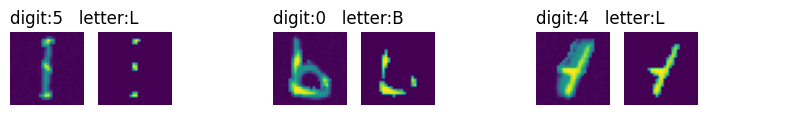

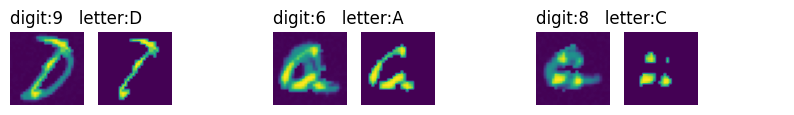

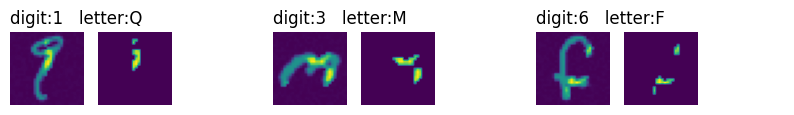

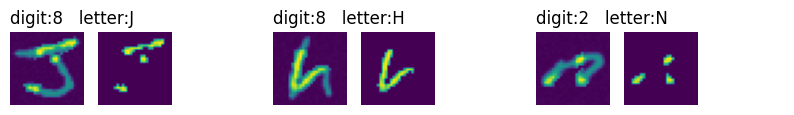

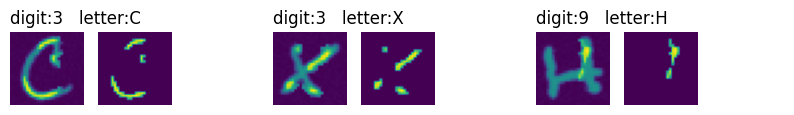

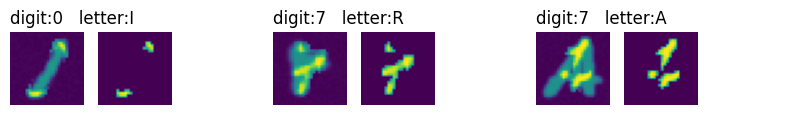

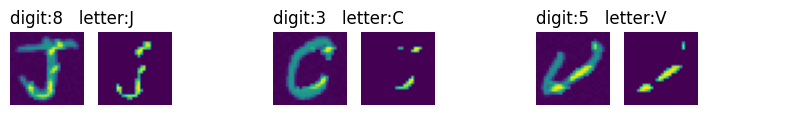

In [ ]:
for idx in range(0, 20, 3):
    plt.figure(figsize = (10,20))

    plt.subplot(1,9,1)
    plt.imshow(train_img[idx].reshape(28,28))
    plt.axis('off')

    plt.title('digit:{}   letter:{}'.format(train_digit[idx], train_letter[idx]), loc = 'left', fontsize = 12)



    plt.subplot(1,9,2)
    data = np.where(train_img>=150, train_img, 0)
    plt.imshow(data[idx].reshape(28,28))
    plt.axis('off')

    plt.subplot(1,9,3)
    plt.imshow(np.zeros((28,28,3))+1)
    plt.axis('off')


    plt.subplot(1,9,4)
    plt.imshow(train_img[idx+1].reshape(28,28))
    plt.axis('off')

    plt.title('digit:{}   letter:{}'.format(train_digit[idx+1], train_letter[idx+1]), loc = 'left', fontsize = 12)



    plt.subplot(1,9,5)
    data = np.where(train_img>=150, train_img, 0)
    plt.imshow(data[idx+1].reshape(28,28))
    plt.axis('off')

    plt.subplot(1,9,6)
    plt.imshow(np.zeros((28,28,3))+1)
    plt.axis('off')

    plt.subplot(1,9,7)
    plt.imshow(train_img[idx+2].reshape(28,28))
    plt.axis('off')

    plt.title('digit:{}   letter:{}'.format(train_digit[idx+2], train_letter[idx+2]), loc = 'left', fontsize = 12)



    plt.subplot(1,9,8)
    data = np.where(train_img>=150, train_img, 0)
    plt.imshow(data[idx+2].reshape(28,28))
    plt.axis('off')

    plt.subplot(1,9,9)
    plt.imshow(np.zeros((28,28,3))+1)
    plt.axis('off')

plt.show()

기존 MNIST 데이터셋의 숫자 손글씨에 알파벳을 그린 뒤 알파벳과 숫자가 겹치는 부분만 남기는 식으로 데이터가 만들어진 것으로 보인다. 즉, 문자 속에 숨어있는 숫자를 예측하는 문제라고 생각할 수 있을 것이다.

$$
\\
$$

문자(`letter`)를 고려하지 않고 이미지(픽셀)만으로 숫자(`digit`)를 유추하는 훈련을 해도 되겠지만, 문자(`letter`)를 활용할 방법도 고민해볼 필요가 있을 것으로 보인다.

$$
\\
$$

# Baseline

https://dacon.io/competitions/official/235626/codeshare/1538?page=1&dtype=view

## Data Preprocessing

In [ ]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis = 2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1638, 1, 810), (410, 1, 810), (1638,), (410,))

In [ ]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(
    X_train[:, :, :26], # Letter
    X_train[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_train # Label
)

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler = train_sampler, batch_size = batch_size)

validation_data = TensorDataset(
    X_valid[:, :, :26], # Letter
    X_valid[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_valid # Label
)

validation_sampler = SequentialSampler(
    validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler = validation_sampler, batch_size = batch_size)

$$
\\
$$

## Network

In [ ]:
# Model Construct

class ConvClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding = 1), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding = 1), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding = 2), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding = 2), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.ReLU()
        )

        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding = 2), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding = 3), nn.ReLU(),
            nn.Conv2d(256, 512, 9, padding = 3), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding = 3), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding = 3), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding = 3), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding = 3), nn.ReLU()
        )

        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(22016, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )

        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out

    def _inference(self, x1, x2):
        bsz = x1.size(0)

        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)

        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)

        return out

$$
\\
$$

## Train

### Setting

In [ ]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (9): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): Conv2d(512, 256, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1),

In [ ]:
# Optimizer and hyperparameters

from torch.optim import Adam

optimizer = Adam(
    model.parameters(),
    lr = 2e-5, # 학습률
    eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 100

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda")

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Null container (record and plot)
acc_base = []

$$
\\
$$

### Training Cycle

In [ ]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
history = defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행
        outputs = model(x1, x2, label)

        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())

        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(x1, x2, label)

        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    acc_base.append(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 100/100] Avg Training Loss: 1.64 Valid Acc: 0.62
Training complete!


In [ ]:
# 결과 parameter 저장
torch.save(model.state_dict(), 'cnn.pt')

$$
\\
$$

### Training Result: Validation accuracy

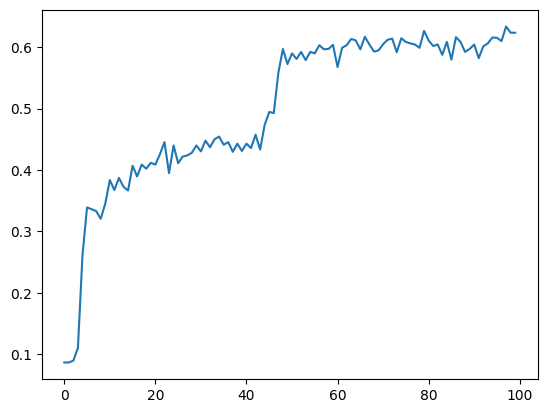

In [ ]:
plt.plot(acc_base)
plt.savefig(path_plot + '/base_adam.png')

$$
\\
$$

## Test

### Data Preprocessing

In [ ]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

$$
\\
$$

### Setting

In [ ]:
# 모델을 로드하여 test를 진행
model = ConvClassifier()
model.load_state_dict(torch.load('cnn.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (9): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): Conv2d(512, 256, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1),

$$
\\
$$

### Implementation

In [ ]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

$$
\\
$$

### Result

In [ ]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()

submission.to_csv(path_submission + '/base_adam.csv', index = False)

## Test Accuracy: 62%

$$
\\
$$

# Batch Normalization

## Data Preprocessing

In [ ]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis = 2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1638, 1, 810), (410, 1, 810), (1638,), (410,))

In [ ]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(
    X_train[:, :, :26], # Letter
    X_train[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_train # Label
)

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler = train_sampler, batch_size = batch_size)

validation_data = TensorDataset(
    X_valid[:, :, :26], # Letter
    X_valid[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_valid # Label
)

validation_sampler = SequentialSampler(
    validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler = validation_sampler, batch_size = batch_size)

$$
\\
$$

## Network

In [ ]:
# Model Construct

class ConvClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding = 1), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding = 1), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding = 2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding = 2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.BatchNorm1d(16), nn.ReLU()
        )

        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding = 2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, 9, padding = 3), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding = 3), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding = 3), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding = 3), nn.BatchNorm2d(32), nn.ReLU()
        )

        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(22016, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )

        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out

    def _inference(self, x1, x2):
        bsz = x1.size(0)

        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)

        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)

        return out

$$
\\
$$

## Train

### Setting

In [ ]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr = 2e-5, # 학습률
    eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 100

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda")

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
acc_bn = []

$$
\\
$$

### Training Cycle

In [ ]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
history = defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행
        outputs = model(x1, x2, label)

        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())

        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(x1, x2, label)

        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    acc_bn.append(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 100/100] Avg Training Loss: 1.46 Valid Acc: 0.80
Training complete!


In [ ]:
# 결과 parameter 저장
torch.save(model.state_dict(), 'cnn.pt')

$$
\\
$$

### Training Result: Validation accuracy

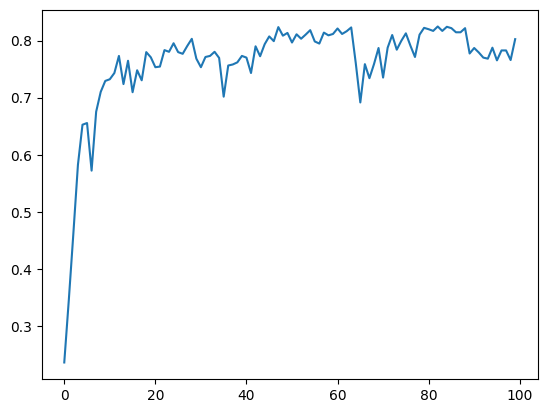

In [ ]:
plt.plot(acc_bn)
plt.savefig(path_plot + '/bn_adam.png')

$$
\\
$$

## Test

### Data Preprocessing

In [ ]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

$$
\\
$$

### Setting

In [ ]:
# 모델을 로드하여 test를 진행
model = ConvClassifier()
model.load_state_dict(torch.load('cnn.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

$$
\\
$$

### Implementation

In [ ]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

$$
\\
$$

### Result

In [ ]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()

submission.to_csv(path_submission + '/bn_adam.csv', index = False)

## Test Accuracy: 약 81%

$$
\\
$$

$$
\\
$$

# BN + Data Augmentation

```
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # 최대 15도 회전
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 수평 뒤집기
    transforms.RandomVerticalFlip(p=0.5),  # 50% 확률로 수직 뒤집기
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 밝기, 대비, 채도 조정
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # 랜덤 크롭 및 크기 조정
    transforms.ToTensor(),  # PIL 이미지 또는 NumPy ndarray를 PyTorch 텐서로 변환
    transforms.Normalize(mean=[0.5], std=[0.5])  # 정규화 (채널별 평균과 표준편차)
])
```

## Defining `transform` for data augmentation

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, GaussianBlur, RandomAffine, ToPILImage

In [ ]:
# 데이터 증강을 위한 변환 정의 2
transforms = Compose([
    ToTensor(),
    # Normalize(mean=[0.5], std=[0.5]),
    # Resize((28, 28)),
    # GaussianBlur(kernel_size = (3, 3), sigma = (0.1, 0.5)),  # Blur를 살짝만 적용
    RandomAffine(
        degrees=(-1, 1),  # 최대 1도 회전
        scale=(0.99, 1.01),  # 99%에서 101% 사이로 확대/축소
    )
])

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, letters, images, y, transform=None):
        self.letters = letters
        self.images = images
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        letter = self.letters[idx]
        image = self.images[idx]
        label = self.y[idx]

        # 변환 적용
        if self.transform:
            # 이미지를 PIL 형식으로 변환
            image = ToPILImage()(image)
            image = self.transform(image)

        return letter, image, label

$$
\\
$$

## Data Preprocessing

In [ ]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis = 2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [ ]:
# 배치 사이즈
batch_size = 32

train_dataset = AugmentedDataset(X_train[:, :, :26], X_train[:, :, 26:].reshape(-1, 1, 28, 28), y_train, transform=transforms)
valid_dataset = AugmentedDataset(X_valid[:, :, :26], X_valid[:, :, 26:].reshape(-1, 1, 28, 28), y_valid)

# DataLoader 설정
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

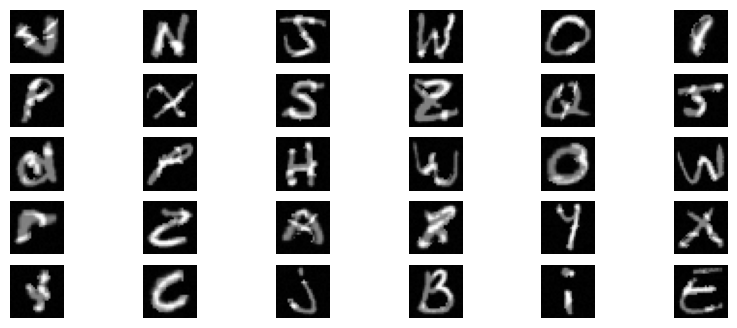

In [ ]:
# 데이터 증강 시각화를 위해 일부 이미지 로드 및 변환
letter, image, label = next(iter(train_dataloader))

# 원본 및 증강된 이미지 시각화
plt.figure(figsize = (10, 4))
for i in range(30):
    # 증강된 이미지
    plt.subplot(5, 6, i+1)
    plt.imshow(image[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

$$
\\
$$

## Network

In [ ]:
# Model Construct

class ConvClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding = 1), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding = 1), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding = 2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding = 2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.BatchNorm1d(16), nn.ReLU()
        )

        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding = 2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, 9, padding = 3), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding = 3), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding = 3), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding = 3), nn.BatchNorm2d(32), nn.ReLU()
        )

        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(22016, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )

        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out

    def _inference(self, x1, x2):
        bsz = x1.size(0)

        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)

        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)

        return out

In [ ]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

$$
\\
$$

## Train

### Setting

In [ ]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr = 2e-5, # 학습률
    eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 100

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda")

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
acc_bn_aug = []

$$
\\
$$

### Training Cycle

In [ ]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
history = defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행
        outputs = model(x1, x2, label)

        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())

        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(x1, x2, label)

        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    acc_bn_aug.append(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 100/100] Avg Training Loss: 1.46 Valid Acc: 0.80
Training complete!


In [ ]:
# 결과 parameter를 저장
torch.save(model.state_dict(), 'cnn.pt')

$$
\\
$$

### Training Result: validation accuracy

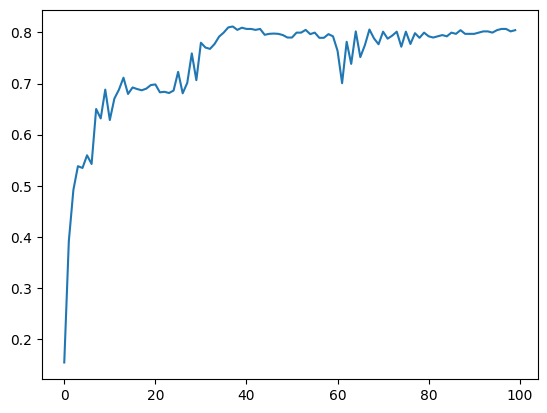

In [ ]:
plt.plot(acc_bn_aug)
plt.savefig(path_plot + '/bn_aug_adam.png')

$$
\\
$$

## Test

### Data Preprocessing

In [ ]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

$$
\\
$$

### Setting

In [ ]:
# 모델을 로드하여 test를 진행
model = ConvClassifier()
model.load_state_dict(torch.load('cnn.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

$$
\\
$$

### Implementation

In [ ]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

$$
\\
$$

### Result

In [ ]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()

submission.to_csv(path_submission + '/bn_aug_adam.csv', index = False)

## Test Accuracy: 약 82%

$$
\\
$$

# BN + Pooling

## Data Preprocessing

In [ ]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis=2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1638, 1, 810), (410, 1, 810), (1638,), (410,))

In [ ]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(
    X_train[:, :, :26], # Letter
    X_train[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_train # Label
)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler = train_sampler, batch_size = batch_size)

validation_data = TensorDataset(
    X_valid[:, :, :26], # Letter
    X_valid[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_valid # Label
)
validation_sampler = SequentialSampler(
    validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler=validation_sampler, batch_size = batch_size)

$$
\\
$$

## Network

In [ ]:
# Model Construct

class ConvClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding = 1), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding = 1), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding = 2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding = 2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.BatchNorm1d(16), nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding = 2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 9, padding = 3), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding = 3), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding = 3), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding = 3), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(1344, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )

        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out

    def _inference(self, x1, x2):
        bsz = x1.size(0)

        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)

        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)

        return out

In [ ]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2)

$$
\\
$$

## Train

### Setting

In [ ]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr = 2e-5, # 학습률
    eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 100

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda")

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
acc_pool = []

$$
\\
$$

### Training Cycle

In [ ]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
history = defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행
        outputs = model(x1, x2, label)

        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())

        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(x1, x2, label)

        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    acc_pool.append(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 100/100] Avg Training Loss: 1.46 Valid Acc: 0.79
Training complete!


In [ ]:
# 결과 parameter를 저장
torch.save(model.state_dict(), 'cnn.pt')

$$
\\
$$

### Training Result: validation accuracy

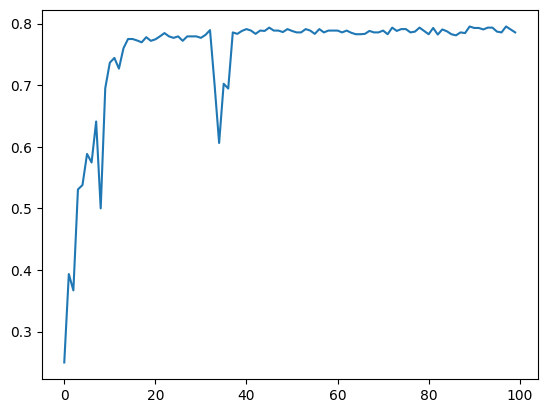

In [ ]:
plt.plot(acc_pool)
plt.savefig(path_plot + '/bn_pool_adam.png')

$$
\\
$$

## Test

### Data Preprocessing

In [ ]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

$$
\\
$$

### Setting

In [ ]:
# 모델을 로드하여 test를 진행할 것임
model = ConvClassifier()
model.load_state_dict(torch.load('cnn.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2)

$$
\\
$$

### Implementation

In [ ]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

$$
\\
$$

### Result

In [ ]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()

submission.to_csv(path_submission + '/bn_pool_adam.csv', index = False)

## Test Accuracy: 약 81%

$$
\\
$$

# BN + Pooling + Dropout

## Data Preprocessing

In [ ]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis=2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1638, 1, 810), (410, 1, 810), (1638,), (410,))

In [ ]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(
    X_train[:, :, :26], # Letter
    X_train[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_train # Label
)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler = train_sampler, batch_size = batch_size)

validation_data = TensorDataset(
    X_valid[:, :, :26], # Letter
    X_valid[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_valid # Label
)
validation_sampler = SequentialSampler(
    validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler=validation_sampler, batch_size = batch_size)

$$
\\
$$

## Network

In [ ]:
# Model Construct

class ConvClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding = 1), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding = 1), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding = 2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding = 2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.BatchNorm1d(16), nn.ReLU(),
            nn.MaxPool1d(2), nn.Dropout(0.3)
        )

        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding = 2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 9, padding = 3), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding = 3), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding = 3), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding = 3), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.3)
        )

        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(1344, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 10)
        )

        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out

    def _inference(self, x1, x2):
        bsz = x1.size(0)

        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)

        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)

        return out

In [ ]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Dro

$$
\\
$$

## Train

### Setting

In [ ]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr = 2e-5, # 학습률
    eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 100

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda")

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
acc_pool_dr = []

$$
\\
$$

### Training Cycle

In [ ]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
history = defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행
        outputs = model(x1, x2, label)

        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())

        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(x1, x2, label)

        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    acc_pool_dr.append(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 100/100] Avg Training Loss: 1.47 Valid Acc: 0.78
Training complete!


In [ ]:
# 결과 parameter를 저장
torch.save(model.state_dict(), 'cnn.pt')

$$
\\
$$

### Training Result: validation accuracy

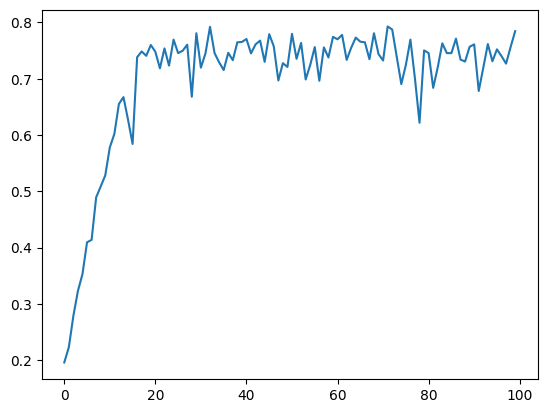

In [ ]:
plt.plot(acc_pool_dr)
plt.savefig(path_plot + '/bn_pool_dr_adam.png')

$$
\\
$$

## Test

### Data Preprocessing

In [ ]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

$$
\\
$$

### Setting

In [ ]:
# 모델을 로드하여 test를 진행할 것임
model = ConvClassifier()
model.load_state_dict(torch.load('cnn.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Dro

$$
\\
$$

### Implementation

In [ ]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

$$
\\
$$

### Result

In [ ]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()

submission.to_csv(path_submission + '/bn_pool_dr_adam.csv', index = False)

## Test Accuracy: 약 76%

$$
\\
$$

# BN + Data Aug. + Pooling

## Defining `transform` for data augmentation

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, GaussianBlur, RandomAffine, ToPILImage

In [ ]:
# 데이터 증강을 위한 변환 정의
transforms = Compose([
    ToTensor(),
    # Normalize(mean=[0.5], std=[0.5]),
    # Resize((28, 28)),
    # GaussianBlur(kernel_size = (3, 3), sigma = (0.1, 0.5)),  # Blur를 살짝만 적용
    RandomAffine(
        degrees=(-1, 1),  # 최대 1도 회전
        scale=(0.99, 1.01),  # 99%에서 101% 사이로 확대/축소
    )
])

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, letters, images, y, transform=None):
        self.letters = letters
        self.images = images
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        letter = self.letters[idx]
        image = self.images[idx]
        label = self.y[idx]

        # 변환 적용
        if self.transform:
            # 이미지를 PIL 형식으로 변환
            image = ToPILImage()(image)
            image = self.transform(image)

        return letter, image, label

$$
\\
$$

## Data Preprocessing

In [ ]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis = 2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [ ]:
# 배치 사이즈
batch_size = 32

train_dataset = AugmentedDataset(X_train[:, :, :26], X_train[:, :, 26:].reshape(-1, 1, 28, 28), y_train, transform=transforms)
valid_dataset = AugmentedDataset(X_valid[:, :, :26], X_valid[:, :, 26:].reshape(-1, 1, 28, 28), y_valid)

# DataLoader 설정
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

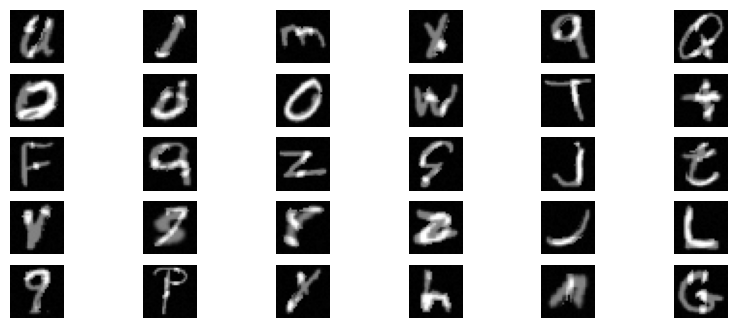

In [ ]:
# 데이터 증강 시각화를 위해 일부 이미지 로드 및 변환
letter, image, label = next(iter(train_dataloader))

# 원본 및 증강된 이미지 시각화
plt.figure(figsize = (10, 4))
for i in range(30):
    # 증강된 이미지
    plt.subplot(5, 6, i+1)
    plt.imshow(image[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

$$
\\
$$

## Network

In [ ]:
# Model Construct

class ConvClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding = 1), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding = 1), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding = 2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding = 2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.BatchNorm1d(16), nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding = 2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 9, padding = 3), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding = 3), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding = 3), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding = 3), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(1344, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )

        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out

    def _inference(self, x1, x2):
        bsz = x1.size(0)

        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)

        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)

        return out

In [ ]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2)

$$
\\
$$

## Train

### Setting

In [ ]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr = 2e-5, # 학습률
    eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 100

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda")

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
acc_aug_pool = []

$$
\\
$$

### Training Cycle

In [ ]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
history = defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행
        outputs = model(x1, x2, label)

        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())

        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(x1, x2, label)

        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    acc_aug_pool.append(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 100/100] Avg Training Loss: 1.46 Valid Acc: 0.80
Training complete!


In [ ]:
# 결과 parameter를 저장
torch.save(model.state_dict(), 'cnn.pt')

$$
\\
$$

### Training Result: validation accuracy

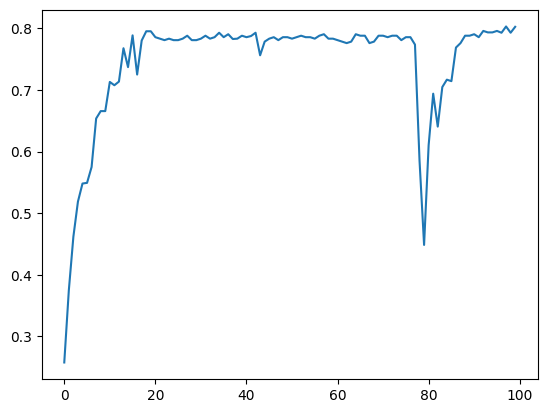

In [ ]:
plt.plot(acc_aug_pool)
plt.savefig(path_plot + '/bn_aug_pool_adam.png')

$$
\\
$$

## Test

### Data Preprocessing

In [ ]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

$$
\\
$$

### Setting

In [ ]:
# 모델을 로드하여 test를 진행할 것임
model = ConvClassifier()
model.load_state_dict(torch.load('cnn.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2)

$$
\\
$$

### Implementation

In [ ]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

$$
\\
$$

### Result

In [ ]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()

submission.to_csv(path_submission + '/bn_aug_pool_adam.csv', index = False)

## Test Accuracy: 약 78%

$$
\\
$$

# BN + Aug. + Pooling + Dropout

## Defining `transform` for data augmentation

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, GaussianBlur, RandomAffine, ToPILImage

In [ ]:
# 데이터 증강을 위한 변환 정의
transforms = Compose([
    ToTensor(),
    # Normalize(mean=[0.5], std=[0.5]),
    # Resize((28, 28)),
    # GaussianBlur(kernel_size = (3, 3), sigma = (0.1, 0.5)),  # Blur를 살짝만 적용
    RandomAffine(
        degrees=(-1, 1),  # 최대 1도 회전
        scale=(0.99, 1.01),  # 99%에서 101% 사이로 확대/축소
    )
])

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, letters, images, y, transform=None):
        self.letters = letters
        self.images = images
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        letter = self.letters[idx]
        image = self.images[idx]
        label = self.y[idx]

        # 변환 적용
        if self.transform:
            # 이미지를 PIL 형식으로 변환
            image = ToPILImage()(image)
            image = self.transform(image)

        return letter, image, label

$$
\\
$$

## Data Preprocessing

In [ ]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis = 2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [ ]:
# 배치 사이즈
batch_size = 32

train_dataset = AugmentedDataset(X_train[:, :, :26], X_train[:, :, 26:].reshape(-1, 1, 28, 28), y_train, transform=transforms)
valid_dataset = AugmentedDataset(X_valid[:, :, :26], X_valid[:, :, 26:].reshape(-1, 1, 28, 28), y_valid)

# DataLoader 설정
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

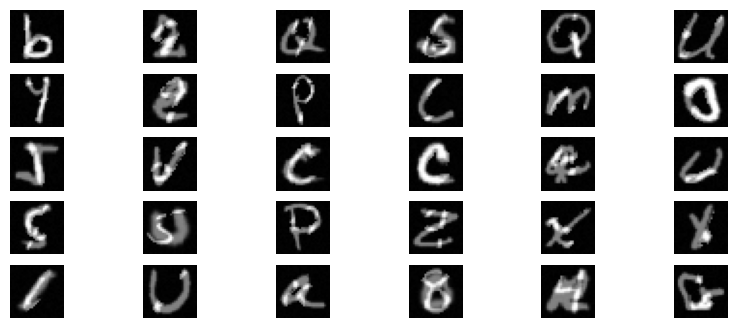

In [ ]:
# 데이터 증강 시각화를 위해 일부 이미지 로드 및 변환
letter, image, label = next(iter(train_dataloader))

# 원본 및 증강된 이미지 시각화
plt.figure(figsize = (10, 4))
for i in range(30):
    # 증강된 이미지
    plt.subplot(5, 6, i+1)
    plt.imshow(image[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

$$
\\
$$

## Network

In [ ]:
# Model Construct

class ConvClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding = 1), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding = 1), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding = 2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding = 2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.BatchNorm1d(16), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )

        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding = 2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 9, padding = 3), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding = 3), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding = 3), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding = 3), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding = 3), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(1344, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 10)
        )

        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out

    def _inference(self, x1, x2):
        bsz = x1.size(0)

        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)

        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)

        return out

In [ ]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Dro

$$
\\
$$

## Train

### Setting

In [ ]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr = 2e-5, # 학습률
    eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 100

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda")

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
acc_aug_pool_dr = []

$$
\\
$$

### Training Cycle

In [ ]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
history = defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행
        outputs = model(x1, x2, label)

        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())

        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        x1, x2, label = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(x1, x2, label)

        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    acc_aug_pool_dr.append(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 100/100] Avg Training Loss: 1.47 Valid Acc: 0.75
Training complete!


In [ ]:
# 결과 parameter를 저장
torch.save(model.state_dict(), 'cnn.pt')

$$
\\
$$

### Training Result: validation accuracy

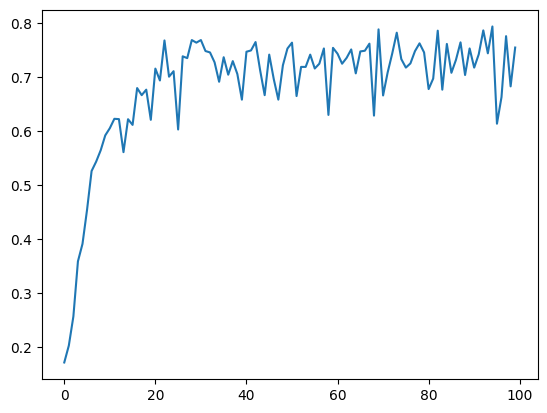

In [ ]:
plt.plot(acc_aug_pool_dr)
plt.savefig(path_plot + '/bn_aug_pool_dr_adam.png')

$$
\\
$$

## Test

### Data Preprocessing

In [ ]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ],
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

$$
\\
$$

### Setting

In [ ]:
# 모델을 로드하여 test를 진행할 것임
model = ConvClassifier()
model.load_state_dict(torch.load('cnn.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Dro

$$
\\
$$

### Implementation

In [ ]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

$$
\\
$$

### Result

In [ ]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()

submission.to_csv(path_submission + '/bn_aug_pool_dr_adam.csv', index = False)

## Test Accuracy: 약 75%

$$
\\
$$

# Training Summary

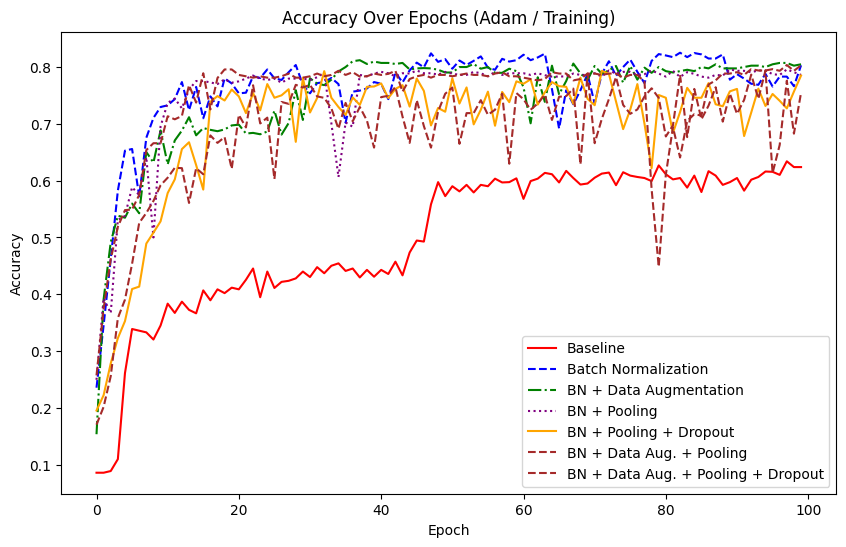

In [ ]:
# Setting
plt.figure(figsize = (10, 6))

plt.plot(acc_base, label = 'Baseline', color = 'red', linestyle='-')
plt.plot(acc_bn, label = 'Batch Normalization', color = 'blue', linestyle='--')
plt.plot(acc_bn_aug, label = 'BN + Data Augmentation', color = 'green', linestyle='-.')
plt.plot(acc_pool, label = 'BN + Pooling', color = 'purple', linestyle=':')
plt.plot(acc_pool_dr, label = 'BN + Pooling + Dropout', color = 'orange', linestyle='-')
plt.plot(acc_aug_pool, label = 'BN + Data Aug. + Pooling', color = 'brown', linestyle='--')
plt.plot(acc_aug_pool_dr, label = 'BN + Data Aug. + Pooling + Dropout', color = 'brown', linestyle='--')

# Title and label
plt.title('Accuracy Over Epochs (Adam / Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Export
plt.savefig(path_plot + '/summary.png')

$$
\\
$$

# Test Summary

- Baseline: 62%
- Batch Normalization: 82%
- BN + Data Augmentation: 82%
- BN + Pooling: 81%
- BN + Pooling + Dropout: 76%
- BN + Data Augmentation + Pooling: 78%
- BN + Data Aug. + Pooling + Dropout: 75%